 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada" data-toc-modified-id="Cats-and-Dogs-(2):-Usando-uma-rede-pré-treinada-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Cats and Dogs (2): Usando uma rede pré-treinada</a></span><ul class="toc-item"><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Dataset" data-toc-modified-id="Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Construção-da-rede-neural" data-toc-modified-id="Construção-da-rede-neural-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Construção da rede neural</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Geração-de-features-convolucionais" data-toc-modified-id="Geração-de-features-convolucionais-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Geração de <em>features</em> convolucionais</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Treinamento-da-camada-densa-utilizando-as-features" data-toc-modified-id="Treinamento-da-camada-densa-utilizando-as-features-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Treinamento da camada densa utilizando as <em>features</em></a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Fine-tunning" data-toc-modified-id="Fine-tunning-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Fine tunning</a></span></li><li><span><a href="https://gpu-nm.ddns.net/jupyterhub/user/yugo4k/notebooks/yugo4k/git/robertoalotufo/rnap/PyTorch/transfer_learning_catsdogs.ipynb#Aprendizados-com-este-notebook" data-toc-modified-id="Aprendizados-com-este-notebook-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Aprendizados com este notebook</a></span></li></ul></li></ul></div>

# Cats and Dogs (2): Usando uma rede pré-treinada

Este é o segundo dos dois notebooks sobre *data augmentation*, *transfer learning* e *fine tunning*.

Serão apresentadas abaixo as técnicas de *transfer learning* e *fine tunning*.

Neste notebook utilizam-se as camadas convolucionais de uma rede VGG já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.utils.data
import torch.optim.lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision.models.resnet import BasicBlock

from lib import pytorch_trainer as ptt

## Dataset

In [2]:
class CatsDogsDataset(torch.utils.data.Dataset):
    def __init__(self, rootdir, train=True, transform=None):
        self.train = train
        self.transform = transform
        if self.train:
            self.dirpath = os.path.join(rootdir, 'train')
        else:
            self.dirpath = os.path.join(rootdir, 'validation')
        print(self.dirpath)
        self.l_filepaths = [fp for fp in sorted(glob.glob(os.path.join(self.dirpath, '**'), recursive=True))
                          if fp[-4:].lower() == '.jpg']
    def __len__(self):
        return len(self.l_filepaths)
    def __getitem__(self, index):
        fp = self.l_filepaths[index]
#         out = np.float32(os.path.basename(fp)[:3].lower() == 'dog')
        out = int(os.path.basename(fp)[:3].lower() == 'dog')
        inp = PIL.Image.open(fp)
        if self.transform is not None:
            inp = self.transform(inp)
        return inp, out
rootdir = '/data/datasets/catsdogs_fewsamples'
size_final = (150, 150)
transf_comp_train = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

transf_comp_valid = torchvision.transforms.Compose([torchvision.transforms.Scale(size=size_final),
                                                    torchvision.transforms.ToTensor()])

dataset_train = CatsDogsDataset(rootdir, train=True, transform=transf_comp_train)
dataset_valid = CatsDogsDataset(rootdir, train=False, transform=transf_comp_valid)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
x_train, y_train = next(iter(loader_train))
x_valid, y_valid = next(iter(loader_valid))

# batch_size = 100
# loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

/data/datasets/catsdogs_fewsamples/train
/data/datasets/catsdogs_fewsamples/validation


## Construção da rede neural
O *transfer learning* permite que utilizemos uma rede já treinada (a *ResNet34*, utilizando apenas uma parte convolucional da rede) para gerar um vetor de features. Essa primeira parte do modelo será chamado de *MyResNetConv*.

É possível utilizar esse vetor de features como entrada de uma rede densa simples, que terá como *output* a saída que será comparada com o resultado desejado. Essa parte final do modelo será chamada de *MyResNetDens*.

Essas duas partes serão integradas no modelo *MyResNet*, com o benefício de podermos utilizar a primeira parte para gerar as *features* convolucionais, que serão utilizadas no treinamento exclusivo da segunda parte.

In [3]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [3, 4, 6, 3])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet34-333f7ec4.pth'))
#         super().__init__(BasicBlock, [2, 2, 2, 2])
#         self.load_state_dict(torch.utils.model_zoo.load_url(
#             'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
#         del self.layer2
#         del self.layer3
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
#         x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(nn.Module):
    def __init__(self):
        super().__init__()
#         self.dens1 = nn.Linear(in_features=256, out_features=2)
#         self.dens1 = nn.Linear(in_features=64*5*5, out_features=2)
#         self.dens1 = nn.Linear(in_features=128*2*2, out_features=2)
#         self.sigm1 = nn.Sigmoid()
        self.dens1 = nn.Linear(in_features=256, out_features=50)
        self.relu1 = nn.ReLU()
        self.dens2 = nn.Linear(in_features=50, out_features=2)
    def forward(self, x):
#         x = self.dens1(x)
#         x = self.sigm1(x)
        x = self.dens1(x)
        x = self.relu1(x)
        x = self.dens2(x)
        return x

class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mrn_conv = MyResNetConv()
        self.mrn_dens = MyResNetDens()
    def forward(self, x):
        x = self.mrn_conv(x)
        x = self.mrn_dens(x)
        return x

model = MyResNet()
if torch.cuda.is_available:
    model.cuda()
# print(model)

# o0 = model(Variable(x_train[:17].cuda()))
# print(o0.data.size())

# o1 = model.mrn_conv(Variable(x_train[:17].cuda()))
# print(o1.data.size())

# o2 = model.mrn_dens(o1)
# print(o2.data.size())

## Geração de *features* convolucionais

In [4]:
inp_train = x_train
inp_valid = x_valid
if torch.cuda.is_available():
    inp_train = inp_train.cuda()
    inp_valid = inp_valid.cuda()
inp_train = Variable(inp_train)
inp_valid = Variable(inp_valid)

model.mrn_conv.eval()
feat_train = model.mrn_conv(inp_train).data
feat_valid = model.mrn_conv(inp_valid).data

# trainer_conv = ptt.DeepNetTrainer(model     = model.mrn_conv,
#                                   criterion = nn.CrossEntropyLoss(),
#                                   optimizer = torch.optim.Adam(params=model.mrn_dens.parameters()))
# feat_train = trainer_conv.predict_loader(loader_train).data
# feat_valid = trainer_conv.predict_loader(loader_valid).data

print(feat_train.size())
print(feat_valid.size())

torch.Size([2000, 256])
torch.Size([800, 256])


## Treinamento da camada densa utilizando as *features*

In [5]:
n_epochs = 10
optm = torch.optim.Adam(params=model.mrn_dens.parameters(), lr=1.e-2, betas=(0.9, 0.999))
# optm = torch.optim.Adam(params=model.mrn_dens.parameters(), lr=1e-1)
# optm = torch.optim.RMSprop(params=model.mrn_dens.parameters())
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_features_catsdogs', reset=True, verbose=1)

trainer_dens = ptt.DeepNetTrainer(model         = model.mrn_dens,
                                  criterion     = nn.CrossEntropyLoss(),
                                  optimizer     = optm,
                                  lr_scheduler  = schd,
                                  callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer_dens.fit(n_epochs   = n_epochs,
                     Xin        = feat_train,
                     Yin        = y_train,
                     shuffle    = True,
                     batch_size = 100,
                     valid_data = (feat_valid, y_valid))
else:
    trainer_dens.load_state('/data/models/transferlearning_features_catsdogs')

Start training for 10 epochs
  1:   0.7s   T: 0.48897 0.80300   V: 0.23285 0.92375 best
  2:   0.0s   T: 0.18450 0.93050   V: 0.14593 0.93750 best
  3:   0.0s   T: 0.14271 0.94150   V: 0.14614 0.93750 
  4:   0.0s   T: 0.12929 0.94550   V: 0.14101 0.93500 best
  5:   0.0s   T: 0.11934 0.95150   V: 0.12570 0.94750 best
  6:   0.0s   T: 0.11389 0.95050   V: 0.12087 0.94875 best
  7:   0.0s   T: 0.09994 0.96000   V: 0.13753 0.94750 
  8:   0.0s   T: 0.10836 0.95150   V: 0.13246 0.95000 
  9:   0.0s   T: 0.10398 0.95950   V: 0.13918 0.94750 
 10:   0.0s   T: 0.08792 0.96550   V: 0.12903 0.94750 
Best model was saved at epoch 6 with loss 0.12087: ../../models/transferlearning_features_catsdogs
Stop training at epoch: 10/10


In [6]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']))
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

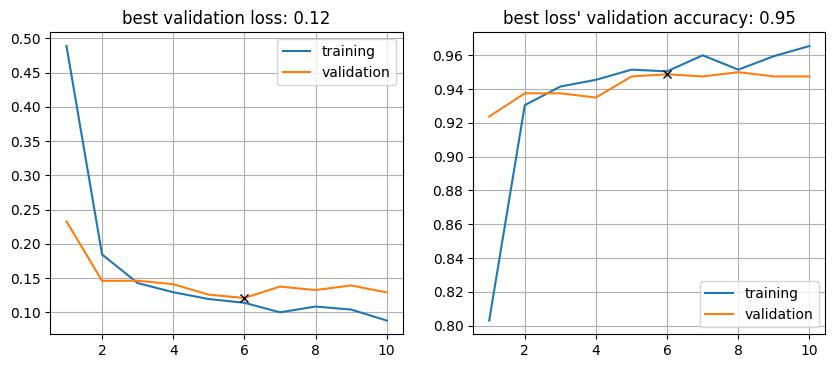

In [7]:
show_history(trainer_dens)

In [8]:
trainer_dens.load_state('/data/models/transferlearning_features_catsdogs')

KeyError: 'unexpected key "mrn_conv.conv1.weight" in state_dict'

## Fine tunning
É possível ainda refazer o treinamento da camada densa junto ao último bloco convolucional da rede *ResNet*, mantendo todas as outras camadas fixas e utilizando um *learning rate* com valor bem baixo.

In [9]:
# model.train()
# for param in model.mrn_conv.layer3[5].parameters():
#     param.requires_grad = True
# for param in model.mrn_dens.parameters():
#     param.requires_grad = True
for param in model.parameters():
    param.requires_grad = True

batch_size = 40
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

n_epochs = 50
optm = torch.optim.Adam(params=model.parameters(),  lr=1.e-4)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_finetunning_catsdogs', reset=True, verbose=1)

trainer_finetunning = ptt.DeepNetTrainer(model         = model,
                                         criterion     = nn.CrossEntropyLoss(),
                                         optimizer     = optm,
                                         lr_scheduler  = schd,
                                         callbacks = [cb_chkpt, ptt.AccuracyMetric(), ptt.PrintCallback()])

train = True
if train:
    trainer_finetunning.fit_loader(n_epochs, loader_train, loader_valid)
else:
    trainer_finetunning.load_state('/data/models/transferlearning_finetunning_catsdogs')

Start training for 50 epochs
  1:  10.3s   T: 0.12598 0.95000   V: 0.12501 0.96000 best
  2:  10.3s   T: 0.01723 0.99400   V: 0.11339 0.95875 best
  3:  10.3s   T: 0.00201 0.99950   V: 0.09111 0.97125 best
  4:  10.3s   T: 0.00107 1.00000   V: 0.09064 0.97000 best
  5:  10.3s   T: 0.00055 1.00000   V: 0.09030 0.97250 best
  6:  10.3s   T: 0.00026 1.00000   V: 0.09310 0.97250 
  7:  10.3s   T: 0.00016 1.00000   V: 0.09262 0.97000 
  8:  10.3s   T: 0.00024 1.00000   V: 0.09452 0.96875 
  9:  10.3s   T: 0.00029 1.00000   V: 0.09422 0.97000 
 10:  10.3s   T: 0.00011 1.00000   V: 0.09254 0.97000 
 11:  10.3s   T: 0.00016 1.00000   V: 0.09648 0.97250 
 12:  10.3s   T: 0.00012 1.00000   V: 0.09414 0.97125 
 13:  10.3s   T: 0.00010 1.00000   V: 0.09252 0.97125 
 14:  10.4s   T: 0.00007 1.00000   V: 0.09474 0.97125 
 15:  10.3s   T: 0.00007 1.00000   V: 0.09511 0.97125 
 16:  10.4s   T: 0.00006 1.00000   V: 0.09675 0.97000 
 17:  10.3s   T: 0.00009 1.00000   V: 0.09439 0.97250 
 18:  10.3s   T:

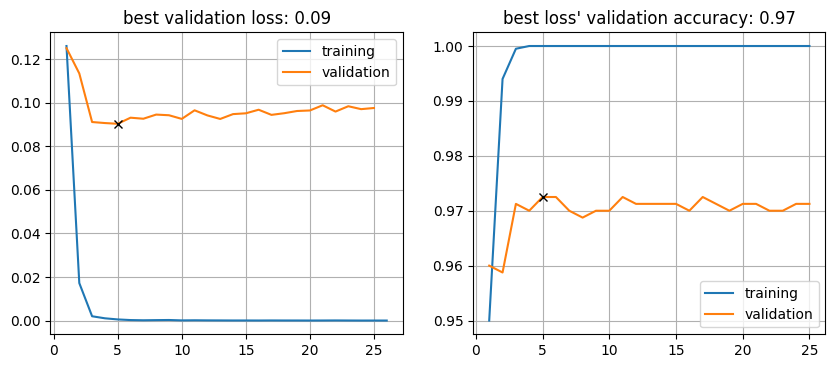

In [10]:
show_history(trainer_finetunning)

## Aprendizados com este notebook

1. O uso de uma rede pré-treinada com pesos utilizados em competições, serve para a extração eficiente de atributos das imagens de um modo geral. 
2. Os *features* gerados pela rede ResNet podem ser utilizados para classificação utilizando qualquer classificador. Neste caso utilizamos um classificador por rede neural densa. Desta forma, podemos em seguida realizar o *fine tunning* fazendo também o treinamento de mais camadas da rede.
